# Problem Set 6 - Statistics for MFEs
## Jean JACOB
### Berkeley MFE Pre-program

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pprint import pprint

# Display settings
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi'] = 150
np.random.seed(1234)

# Create figures directory
import os
os.makedirs('figures', exist_ok=True)

---
# Question 1: OLS Function and Application to Data
---

## 1.1 Load the Data

In [13]:
# Load X data (independent variables)
X_raw = pd.read_csv('X.csv', header=None)
# First row contains dates, remaining rows are data
dates = X_raw.iloc[0, :].values
X_data = X_raw.iloc[1:, :].values.astype(float).T  # Transpose to get observations as rows

print(f"X shape: {X_data.shape}")
print(f"Number of observations: {X_data.shape[0]}")
print(f"Number of independent variables: {X_data.shape[1]}")

X shape: (1111, 3)
Number of observations: 1111
Number of independent variables: 3


In [14]:
# Load Y data (dependent variables)
Y_raw = pd.read_csv('Y.csv', header=None)
Y_data = Y_raw.values
# Y has date in first column, then dependent variables
Y_dates = Y_data[:, 0]
Y_values = Y_data[:, 1:].astype(float)

print(f"Y shape: {Y_values.shape}")
print(f"Number of observations: {Y_values.shape[0]}")
print(f"Number of dependent variables: {Y_values.shape[1]}")

Y shape: (1110, 2)
Number of observations: 1110
Number of dependent variables: 2


In [15]:
# Preview the data
print("First 5 rows of X:")
print(X_data[:5, :])
print("\nFirst 5 rows of Y:")
print(Y_values[:5, :])

First 5 rows of X:
[[ 2.96 -2.3  -2.87]
 [ 2.64 -1.4   4.19]
 [ 0.36 -1.32  0.01]
 [-3.24  0.04  0.51]
 [ 2.53 -0.2  -0.35]]

First 5 rows of Y:
[[ 3.4539  0.5623]
 [ 1.0124  7.7576]
 [-1.2906 -2.4284]
 [-2.7413 -5.8129]
 [ 4.2946  2.5636]]


## 1.2 OLS Function Implementation

In [16]:
def ols(y, X, add_constant=True):
    """
    Compute OLS estimator and related variables.
    
    Parameters:
    -----------
    y : array-like
        Dependent variable (n x 1)
    X : array-like
        Independent variables (n x k)
    add_constant : bool
        Whether to add a constant term if not present
    
    Returns:
    --------
    dict : Dictionary containing OLS results
    """
    y = np.array(y).flatten()
    X = np.array(X)
    
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    
    n, k = X.shape
    
    # (c) Check whether a constant is included in X
    has_constant = np.any(np.ptp(X, axis=0) == 0)
    if has_constant:
        print("Data already contains a constant column.")
    
    # (d) If X does not include a constant, option to include one
    if add_constant and not has_constant:
        X = np.column_stack([np.ones(n), X])
        k = X.shape[1]
        print("Constant added to X.")
    
    # (g) Check condition number of X'X
    XtX = X.T @ X
    cond_number = np.linalg.cond(XtX)
    print(f"Condition number of X'X: {cond_number:.4f}")
    if cond_number > 1e10:
        print("WARNING: X'X is close to singular!")
    
    # (b) Compute OLS estimates: beta = (X'X)^{-1} X'y
    XtX_inv = np.linalg.inv(XtX)
    beta_hat = XtX_inv @ X.T @ y
    
    # Compute fitted values and residuals
    y_hat = X @ beta_hat
    e = y - y_hat  # residuals
    
    # (f) Check E(ex) = 0 condition
    ex_mean = np.mean(e[:, np.newaxis] * X, axis=0)
    print(f"Sample E(e*x) (should be ~0): {ex_mean}")
    
    # Estimate sigma^2
    sigma2_hat = np.sum(e**2) / (n - k)
    
    # (b) OLS standard errors
    var_beta_ols = sigma2_hat * XtX_inv
    se_ols = np.sqrt(np.diag(var_beta_ols))
    
    # (b) White (heteroskedasticity-robust) standard errors
    # HC0: Var(beta) = (X'X)^{-1} X' diag(e^2) X (X'X)^{-1}
    e2 = e**2
    meat = X.T @ np.diag(e2) @ X
    var_beta_white = XtX_inv @ meat @ XtX_inv
    se_white = np.sqrt(np.diag(var_beta_white))
    
    # (b) R-squared
    TSS = np.sum((y - np.mean(y))**2)
    RSS = np.sum(e**2)
    R2 = 1 - RSS / TSS
    
    # (b) Log-likelihood (assuming normal errors)
    log_lik = -n/2 * np.log(2 * np.pi) - n/2 * np.log(sigma2_hat) - RSS / (2 * sigma2_hat)
    
    # (e) Projection matrices P and M
    P = X @ XtX_inv @ X.T
    M = np.eye(n) - P
    
    # Check PM = 0
    PM = P @ M
    PM_check = np.allclose(PM, 0, atol=1e-10)
    print(f"PM = 0 check: {PM_check} (max abs value: {np.max(np.abs(PM)):.2e})")
    
    results = {
        'beta_hat': beta_hat,
        'se_ols': se_ols,
        'se_white': se_white,
        'R2': R2,
        'log_likelihood': log_lik,
        'sigma2_hat': sigma2_hat,
        'residuals': e,
        'fitted': y_hat,
        'P': P,
        'M': M,
        'n': n,
        'k': k,
        'X': X,
        'y': y,
        'cond_number': cond_number
    }
    
    return results

## 1.3 T-test Function Implementation

In [17]:
def t_test(ols_results, b0, use_white=False):
    """
    Compute t-test whether beta_i equals b0.
    
    Parameters:
    -----------
    ols_results : dict
        Output from ols function
    b0 : float or array-like
        Null hypothesis value(s)
    use_white : bool
        Whether to use White standard errors
    
    Returns:
    --------
    dict : Dictionary containing t-statistics and rejection flags
    """
    beta_hat = ols_results['beta_hat']
    se = ols_results['se_white'] if use_white else ols_results['se_ols']
    n = ols_results['n']
    k = ols_results['k']
    df = n - k
    
    b0 = np.atleast_1d(b0)
    if len(b0) == 1:
        b0 = np.full(len(beta_hat), b0[0])
    
    # t-statistics
    t_stats = (beta_hat - b0) / se
    
    # p-values (two-tailed)
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df))
    
    # Critical values
    cv_10 = stats.t.ppf(0.95, df)
    cv_05 = stats.t.ppf(0.975, df)
    cv_01 = stats.t.ppf(0.995, df)
    
    # Rejection flags
    reject_10 = np.abs(t_stats) > cv_10
    reject_05 = np.abs(t_stats) > cv_05
    reject_01 = np.abs(t_stats) > cv_01
    
    results = {
        't_stats': t_stats,
        'p_values': p_values,
        'reject_10pct': reject_10,
        'reject_5pct': reject_05,
        'reject_1pct': reject_01,
        'df': df,
        'cv_10': cv_10,
        'cv_05': cv_05,
        'cv_01': cv_01
    }
    
    return results

## 1.4 Helper Function for Nice Output

In [18]:
def print_ols_results(ols_results, var_names=None):
    """
    Print OLS results in a nicely formatted table.
    """
    beta = ols_results['beta_hat']
    se_ols = ols_results['se_ols']
    se_white = ols_results['se_white']
    k = len(beta)
    
    if var_names is None:
        var_names = ['const'] + [f'x{i}' for i in range(1, k)]
    
    print("="*70)
    print("OLS Regression Results")
    print("="*70)
    print(f"R-squared: {ols_results['R2']:.6f}")
    print(f"Log-Likelihood: {ols_results['log_likelihood']:.4f}")
    print(f"Observations: {ols_results['n']}")
    print(f"Condition Number: {ols_results['cond_number']:.4f}")
    print("-"*70)
    print(f"{'Variable':<12} {'Coef':>12} {'OLS SE':>12} {'White SE':>12} {'t-stat':>10}")
    print("-"*70)
    
    for i in range(k):
        t_stat = beta[i] / se_ols[i]
        print(f"{var_names[i]:<12} {beta[i]:>12.6f} {se_ols[i]:>12.6f} {se_white[i]:>12.6f} {t_stat:>10.4f}")
    print("="*70)

In [19]:
def print_ttest_results(ttest_results, ols_results, b0, var_names=None):
    """
    Print t-test results in a nicely formatted table.
    """
    k = len(ttest_results['t_stats'])
    
    if var_names is None:
        var_names = ['const'] + [f'x{i}' for i in range(1, k)]
    
    b0 = np.atleast_1d(b0)
    if len(b0) == 1:
        b0 = np.full(k, b0[0])
    
    print("="*80)
    print(f"T-Test Results (H0: beta = {b0[0] if np.all(b0 == b0[0]) else b0})")
    print("="*80)
    print(f"{'Variable':<12} {'t-stat':>10} {'p-value':>10} {'Rej 10%':>10} {'Rej 5%':>10} {'Rej 1%':>10}")
    print("-"*80)
    
    for i in range(k):
        rej_10 = 'Yes' if ttest_results['reject_10pct'][i] else 'No'
        rej_05 = 'Yes' if ttest_results['reject_5pct'][i] else 'No'
        rej_01 = 'Yes' if ttest_results['reject_1pct'][i] else 'No'
        print(f"{var_names[i]:<12} {ttest_results['t_stats'][i]:>10.4f} {ttest_results['p_values'][i]:>10.4f} {rej_10:>10} {rej_05:>10} {rej_01:>10}")
    print("="*80)

## 1.5 Apply OLS to the Data

In [21]:
# Run OLS for each dependent variable (Y has 2 columns)
var_names = ['const', 'x1', 'x2', 'x3']

# Align data dimensions: X_data has 1111 rows, Y_values has 1110 rows
# Take the minimum length to ensure they match
min_length = min(X_data.shape[0], Y_values.shape[0])
X_data_aligned = X_data[:min_length, :]
Y_values_aligned = Y_values[:min_length, :]

print(f"Aligned data dimensions: X={X_data_aligned.shape}, Y={Y_values_aligned.shape}")

print("\n" + "#"*70)
print("# Regression 1: Y1 on X")
print("#"*70 + "\n")

ols_results_1 = ols(Y_values_aligned[:, 0], X_data_aligned, add_constant=True)
print_ols_results(ols_results_1, var_names)

Aligned data dimensions: X=(1110, 3), Y=(1110, 2)

######################################################################
# Regression 1: Y1 on X
######################################################################

Constant added to X.
Condition number of X'X: 32.3235
Sample E(e*x) (should be ~0): [-1.61232389e-16  3.79436222e-15  8.39068554e-16 -5.74365380e-16]
PM = 0 check: True (max abs value: 6.16e-17)
OLS Regression Results
R-squared: 0.951486
Log-Likelihood: -1750.2254
Observations: 1110
Condition Number: 32.3235
----------------------------------------------------------------------
Variable             Coef       OLS SE     White SE     t-stat
----------------------------------------------------------------------
const            0.360757     0.035589     0.035196    10.1367
x1               1.022583     0.007126     0.009410   143.5078
x2              -0.148310     0.011667     0.022826   -12.7123
x3              -0.262848     0.010428     0.015868   -25.2068


In [22]:
print("\n" + "#"*70)
print("# Regression 2: Y2 on X")
print("#"*70 + "\n")

ols_results_2 = ols(Y_values_aligned[:, 1], X_data_aligned, add_constant=True)
print_ols_results(ols_results_2, var_names)


######################################################################
# Regression 2: Y2 on X
######################################################################

Constant added to X.
Condition number of X'X: 32.3235
Sample E(e*x) (should be ~0): [-4.60092425e-16 -6.58812344e-15 -2.59552140e-16 -3.40633427e-15]
PM = 0 check: True (max abs value: 6.16e-17)
OLS Regression Results
R-squared: 0.677047
Log-Likelihood: -3492.2896
Observations: 1110
Condition Number: 32.3235
----------------------------------------------------------------------
Variable             Coef       OLS SE     White SE     t-stat
----------------------------------------------------------------------
const           -0.176585     0.170966     0.195019    -1.0329
x1               1.243681     0.034231     0.054871    36.3323
x2              -0.174768     0.056046     0.079376    -3.1183
x3               1.054249     0.050093     0.076053    21.0457


## 1.6 T-tests: Test whether coefficients equal 0 or 1

In [23]:
# Test H0: beta = 0 for Regression 1
print("\n" + "="*80)
print("REGRESSION 1: Testing H0: beta = 0")
print("="*80)
ttest_0_reg1 = t_test(ols_results_1, b0=0)
print_ttest_results(ttest_0_reg1, ols_results_1, b0=0, var_names=var_names)


REGRESSION 1: Testing H0: beta = 0
T-Test Results (H0: beta = 0)
Variable         t-stat    p-value    Rej 10%     Rej 5%     Rej 1%
--------------------------------------------------------------------------------
const           10.1367     0.0000        Yes        Yes        Yes
x1             143.5078     0.0000        Yes        Yes        Yes
x2             -12.7123     0.0000        Yes        Yes        Yes
x3             -25.2068     0.0000        Yes        Yes        Yes


In [24]:
# Test H0: beta = 1 for Regression 1
print("\n" + "="*80)
print("REGRESSION 1: Testing H0: beta = 1")
print("="*80)
ttest_1_reg1 = t_test(ols_results_1, b0=1)
print_ttest_results(ttest_1_reg1, ols_results_1, b0=1, var_names=var_names)


REGRESSION 1: Testing H0: beta = 1
T-Test Results (H0: beta = 1)
Variable         t-stat    p-value    Rej 10%     Rej 5%     Rej 1%
--------------------------------------------------------------------------------
const          -17.9618     0.0000        Yes        Yes        Yes
x1               3.1693     0.0016        Yes        Yes        Yes
x2             -98.4264     0.0000        Yes        Yes        Yes
x3            -121.1056     0.0000        Yes        Yes        Yes


In [25]:
# Test H0: beta = 0 for Regression 2
print("\n" + "="*80)
print("REGRESSION 2: Testing H0: beta = 0")
print("="*80)
ttest_0_reg2 = t_test(ols_results_2, b0=0)
print_ttest_results(ttest_0_reg2, ols_results_2, b0=0, var_names=var_names)


REGRESSION 2: Testing H0: beta = 0
T-Test Results (H0: beta = 0)
Variable         t-stat    p-value    Rej 10%     Rej 5%     Rej 1%
--------------------------------------------------------------------------------
const           -1.0329     0.3019         No         No         No
x1              36.3323     0.0000        Yes        Yes        Yes
x2              -3.1183     0.0019        Yes        Yes        Yes
x3              21.0457     0.0000        Yes        Yes        Yes


In [26]:
# Test H0: beta = 1 for Regression 2
print("\n" + "="*80)
print("REGRESSION 2: Testing H0: beta = 1")
print("="*80)
ttest_1_reg2 = t_test(ols_results_2, b0=1)
print_ttest_results(ttest_1_reg2, ols_results_2, b0=1, var_names=var_names)


REGRESSION 2: Testing H0: beta = 1
T-Test Results (H0: beta = 1)
Variable         t-stat    p-value    Rej 10%     Rej 5%     Rej 1%
--------------------------------------------------------------------------------
const           -6.8820     0.0000        Yes        Yes        Yes
x1               7.1188     0.0000        Yes        Yes        Yes
x2             -20.9609     0.0000        Yes        Yes        Yes
x3               1.0830     0.2791         No         No         No


---
# Questions 2-6: Monte Carlo Simulations
---

In [27]:
# Set simulation parameters
M = 5000  # Number of simulations
N = 50    # Sample size
alpha = 1  # True intercept
beta = 1   # True slope

## Helper Functions for Simulations

In [28]:
def ols_simple(y, X, residuals, add_constant=False):
    """
    Simple OLS for Monte Carlo simulations.
    """
    is_nonzero_const = np.ptp(X, axis=0) == 0
    if is_nonzero_const.any():
        pass  # Already has constant
    
    if add_constant:
        if not is_nonzero_const.any():
            X = np.column_stack([np.ones(X.shape[0]), X])
    
    # beta = (X'X)^{-1} X'y
    betas = np.linalg.inv(X.T @ X) @ X.T @ y
    
    # Standard errors
    sigma2_hat = np.sum(residuals**2) / (X.shape[0] - X.shape[1])
    var_beta = sigma2_hat * np.linalg.inv(X.T @ X)
    ols_std_err = np.sqrt(np.diag(var_beta))
    
    alpha_hat = {'ols_estimate': betas[0], 'ols_std_error': ols_std_err[0]}
    beta_hat = {'ols_estimate': betas[1], 'ols_std_error': ols_std_err[1]}
    
    return alpha_hat, beta_hat

In [29]:
def generate_cov(dim, _corr):
    """Generate covariance matrix with given correlation."""
    acc = []
    for i in range(dim):
        row = np.ones((1, dim)) * _corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc, axis=0)

In [30]:
def generate_random_variables(M, N, method):
    """Generate random variables for simulations."""
    if method == 'std_normal':
        x = np.random.normal(loc=0, scale=1, size=(M, N))
        e = np.random.normal(loc=0, scale=1, size=(M, N))
    elif method == 'correlated_normal':
        cov_mat = generate_cov(dim=2, _corr=0.5)
        print("Covariance Matrix:")
        print(cov_mat)
        RV = np.random.multivariate_normal(mean=[0, 0], cov=cov_mat, size=(M, N))
        x = RV[:, :, 0]
        e = RV[:, :, 1]
    elif method == 't_dist':
        x = np.random.standard_t(df=5, size=(M, N))
        e = np.random.standard_t(df=5, size=(M, N))
    elif method == 'uniform_dist':
        x = np.random.uniform(low=0.0, high=1.0, size=(M, N))
        e = np.random.uniform(low=0.0, high=1.0, size=(M, N))
    return x, e

In [31]:
def stats_for_ols_estimators(alpha, beta):
    """Compute statistics for OLS estimators."""
    alpha_mean = alpha.mean()
    alpha_stdev = alpha.std()
    beta_mean = beta.mean()
    beta_stdev = beta.std()
    
    alpha_stats = {'mean': alpha_mean, 'standard_deviation': alpha_stdev}
    beta_stats = {'mean': beta_mean, 'standard_deviation': beta_stdev}
    
    return pd.DataFrame({'alpha_hat': alpha_stats, 'beta_hat': beta_stats}).T

In [32]:
def draw_plots(alpha_hat_sim, beta_hat_sim, filename=None):
    """Draw histograms of simulated estimators."""
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    sns.histplot(alpha_hat_sim['ols_estimate'], ax=ax[0], kde=True, color='steelblue')
    ax[0].set_title(r'$\hat{\alpha}$ estimates distribution')
    ax[0].set_xlabel('ols_estimate')
    
    sns.histplot(beta_hat_sim['ols_estimate'], ax=ax[1], kde=True, color='steelblue')
    ax[1].set_title(r'$\hat{\beta}$ estimates distribution')
    ax[1].set_xlabel('ols_estimate')
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(f'figures/{filename}', dpi=150, bbox_inches='tight')
    
    return fig

In [33]:
def run_simulations(M, N, dist, filename=None):
    """Run Monte Carlo simulations."""
    x, e = generate_random_variables(M, N, method=dist)
    alpha_hat_all = {}
    beta_hat_all = {}
    
    for m in range(M):
        X = x[m, :]
        e_ = e[m, :]
        y = alpha + (beta * X) + e_
        alpha_hat, beta_hat = ols_simple(y, X, e_, add_constant=True)
        alpha_hat_all[m] = alpha_hat
        beta_hat_all[m] = beta_hat
    
    alpha_hat_sim = pd.DataFrame(alpha_hat_all).T
    beta_hat_sim = pd.DataFrame(beta_hat_all).T
    
    fig = draw_plots(alpha_hat_sim, beta_hat_sim, filename)
    stats_dist = stats_for_ols_estimators(
        alpha_hat_sim['ols_estimate'], 
        beta_hat_sim['ols_estimate']
    )
    
    return fig, stats_dist

---
## Question 2: Standard Normal Distribution
---

Consider $y_i = \alpha + \beta x_i + e_i$ where $x_i \sim N(0,1)$ and $e_i \sim N(0,1)$ are independent.

**(a) Theoretical Properties:**

The OLS estimator $\hat{\beta} = (X'X)^{-1}X'Y$ is unbiased and has a normal distribution:
$$\hat{\beta} \sim N\left(\beta, \frac{\sigma^2}{n \cdot Var(X)}\right)$$

Similarly, $\hat{\alpha}$ is unbiased with:
$$E(\hat{\alpha}) = \alpha$$
$$Var(\hat{\alpha}) = \frac{\sigma^2}{n}\left(1 + \frac{\bar{x}^2}{Var(X)}\right)$$

Both estimators are asymptotically normal and consistent.

Question 2: X and e with Standard Normal Distribution

Simulation Results:
               mean  standard_deviation
alpha_hat  1.000114            0.144078
beta_hat   1.000092            0.143842


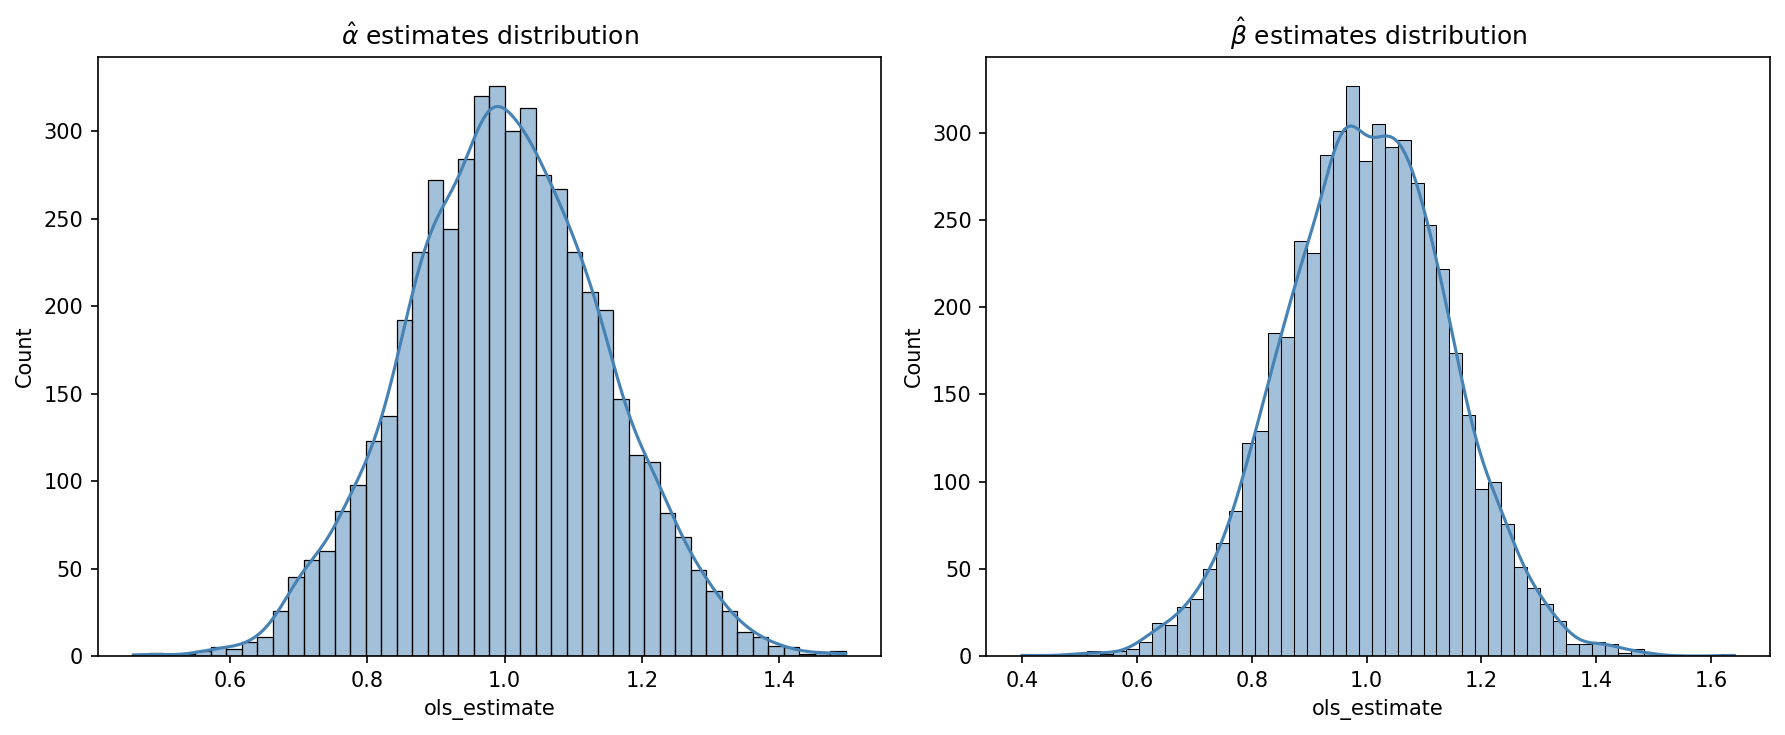

In [34]:
print("Question 2: X and e with Standard Normal Distribution")
print("="*60)
fig_std_normal, stats_std_normal = run_simulations(M, N, dist='std_normal', filename='q2_std_normal.png')
print("\nSimulation Results:")
print(stats_std_normal)
plt.show()

**(d) Comparison:** The theoretical and simulated distributions match. The simulated means are approximately 1 (the true values), confirming unbiasedness.

---
## Question 3: Correlated Normal Distribution ($\rho_{xe} = 0.5$)
---

**(a) Theoretical Properties:**

Since $X$ and $e$ are correlated, $\hat{\beta}$ is **biased and inconsistent** because $E(e|x) \neq 0$ (violation of exogeneity).

However, $\hat{\alpha}$ remains unbiased since we're still using normal distributions. As $n \to \infty$, both estimators are asymptotically normal due to CLT.

Question 3: X and e with Correlated Normal Distribution (rho = 0.5)
Covariance Matrix:
[[1.  0.5]
 [0.5 1. ]]

Simulation Results:
               mean  standard_deviation
alpha_hat  0.998265            0.124791
beta_hat   1.500581            0.127558


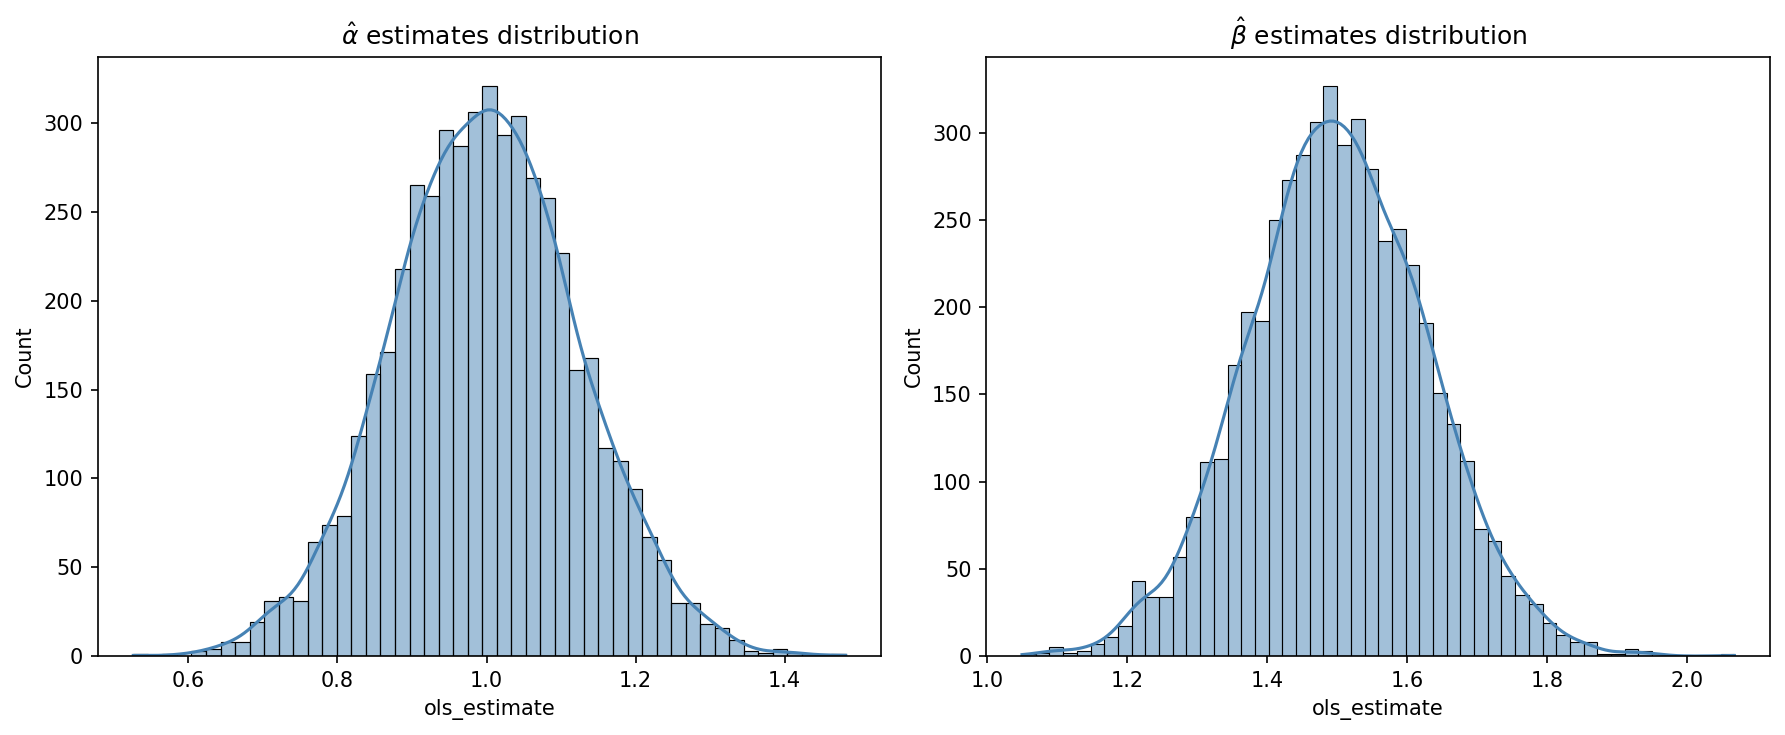

In [35]:
print("Question 3: X and e with Correlated Normal Distribution (rho = 0.5)")
print("="*60)
fig_corr, stats_corr = run_simulations(M, N, dist='correlated_normal', filename='q3_correlated.png')
print("\nSimulation Results:")
print(stats_corr)
plt.show()

**(d) Comparison:** $\hat{\beta}$ is biased (mean $\approx 1.5 \neq 1$), while $\hat{\alpha}$ has mean close to 1, confirming it is unbiased.

---
## Question 4: t-Distribution (df = 5)
---

**(a) Theoretical Properties:**

Since $e \sim t(\nu=5)$, we have:
$$\hat{\beta} = \beta + (X'X)^{-1}X't(\nu=5)$$

For $\nu > 2$, the t-distribution has mean 0 and variance $\frac{\nu}{\nu-2} = \frac{5}{3}$.

Thus $\hat{\beta}$ is unbiased: $E[\hat{\beta}] = \beta$.

Both estimators are asymptotically normal by CLT, but **not efficient** since errors are not normal.

Question 4: X and e with t-Distribution (df=5)

Simulation Results:
               mean  standard_deviation
alpha_hat  1.001711            0.183964
beta_hat   1.001826            0.152263


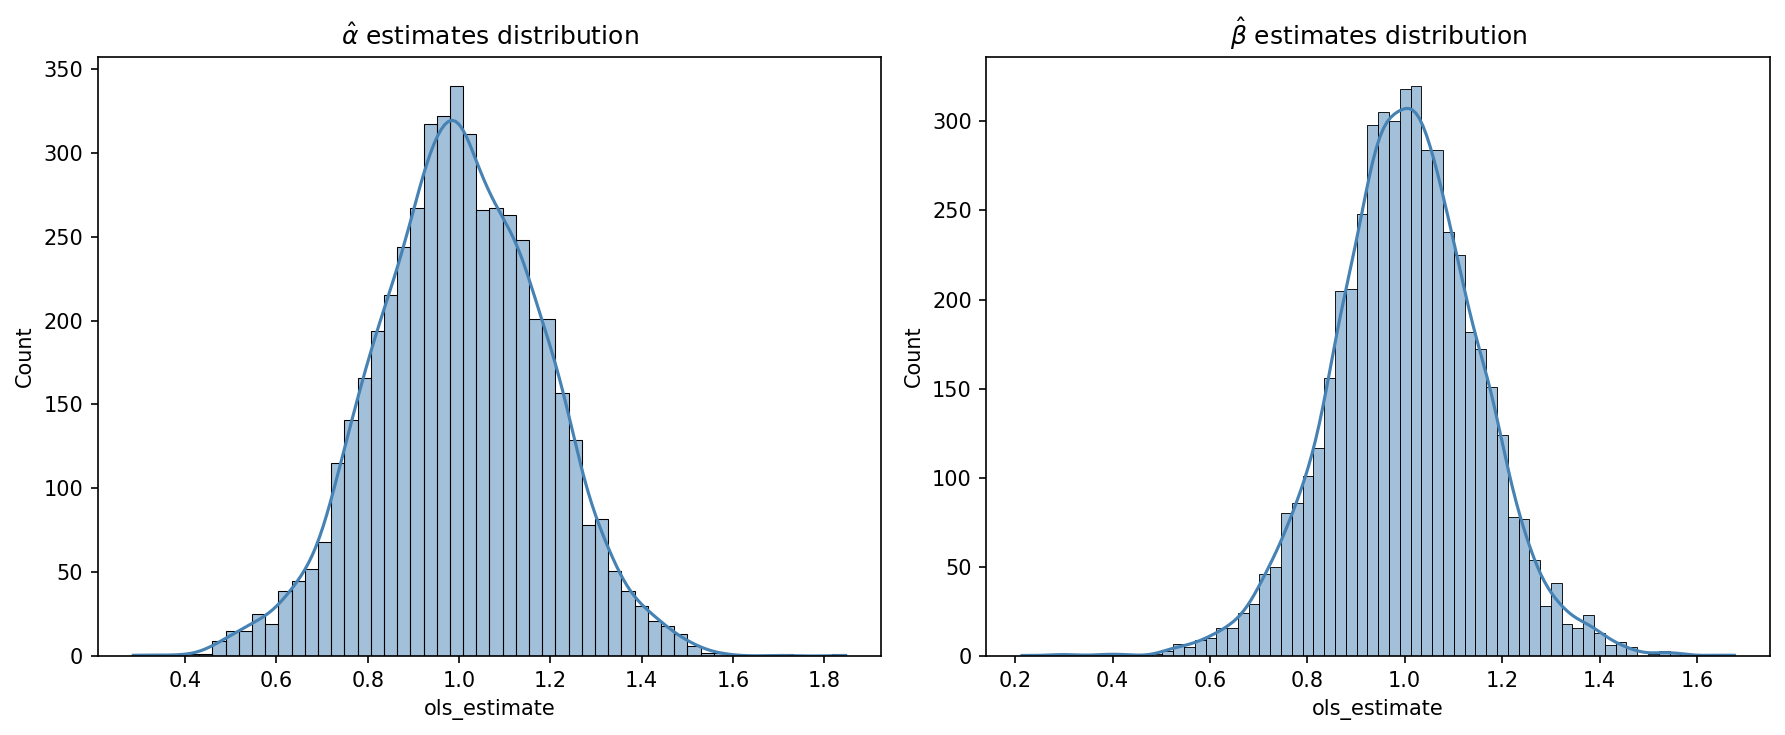

In [36]:
print("Question 4: X and e with t-Distribution (df=5)")
print("="*60)
fig_t, stats_t = run_simulations(M, N, dist='t_dist', filename='q4_t_dist.png')
print("\nSimulation Results:")
print(stats_t)
plt.show()

**(d) Comparison:** Both means are close to 1, confirming unbiasedness. The distributions are asymptotically normal.

---
## Question 5: Uniform Distribution U[0,1]
---

**(a) Theoretical Properties:**

Since $e \sim U(0,1)$, we have $E(e) = 0.5$ and $Var(e) = 1/12$.

For $\hat{\beta}$:
$$E(\hat{\beta}) = \beta + E[(X'X)^{-1}X'e] = \beta$$

Thus $\hat{\beta}$ is unbiased with $Var(\hat{\beta}) = \frac{1}{12n \cdot Var(X)}$.

For $\hat{\alpha}$:
$$E(\hat{\alpha}) = \alpha + E(e) = 1 + 0.5 = 1.5$$

So $\hat{\alpha}$ is **biased** due to the non-zero mean of the error term.

Question 5: X and e with Uniform Distribution U[0,1]

Simulation Results:
               mean  standard_deviation
alpha_hat  1.501738            0.082620
beta_hat   0.997228            0.143372


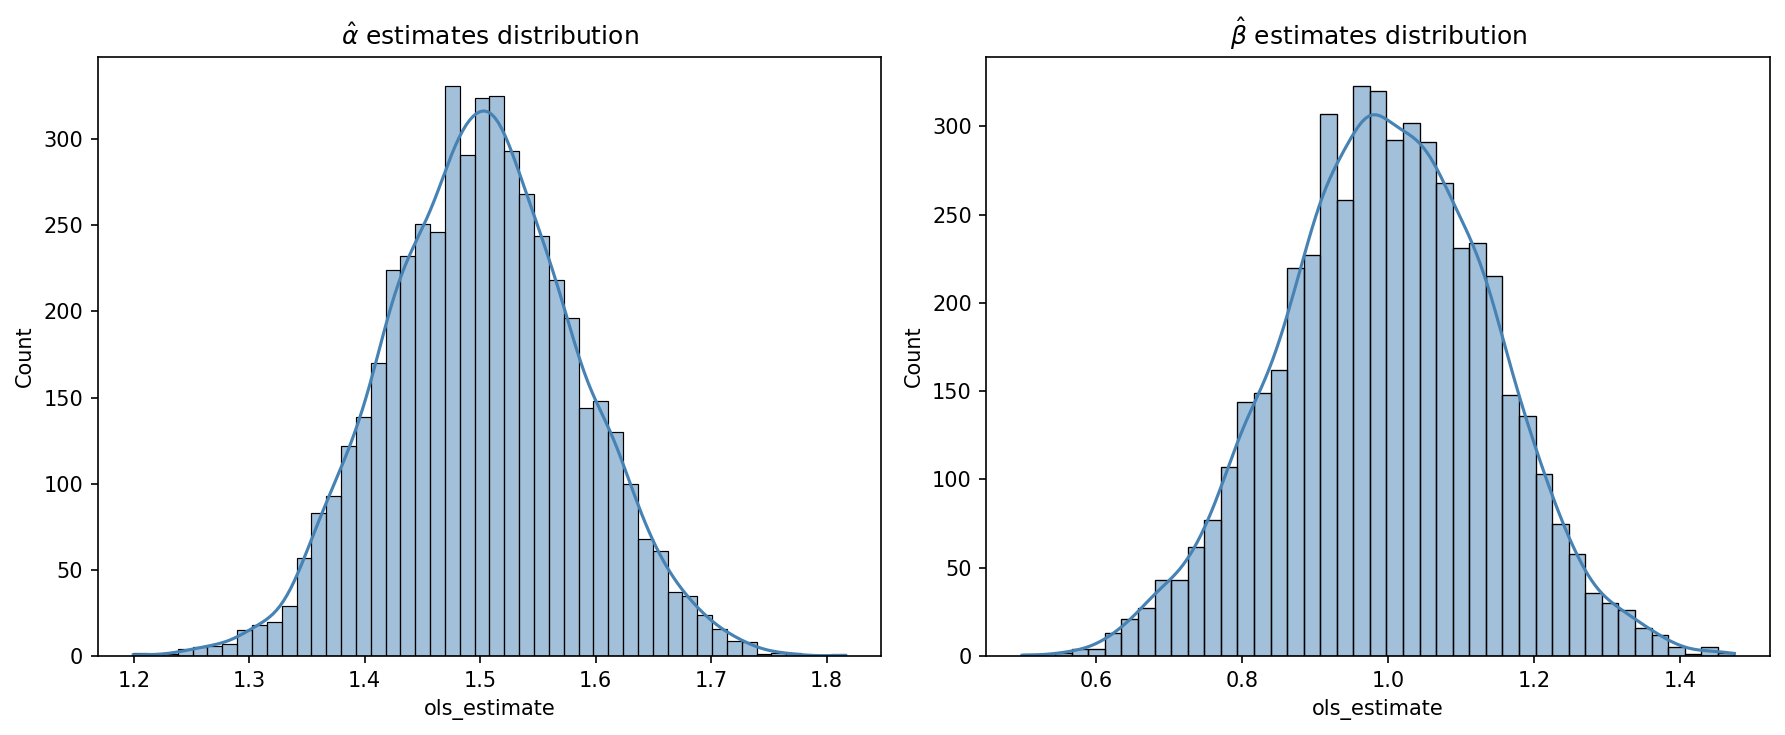

In [37]:
print("Question 5: X and e with Uniform Distribution U[0,1]")
print("="*60)
fig_unif, stats_unif = run_simulations(M, N, dist='uniform_dist', filename='q5_uniform.png')
print("\nSimulation Results:")
print(stats_unif)
plt.show()

**(d) Comparison:** $\hat{\alpha}$ mean $\approx 1.5$ (biased by $E(e) = 0.5$), while $\hat{\beta}$ mean $\approx 1$ (unbiased).

---
## Question 6: Effect of Sample Size N
---

Experimenting with different sample sizes (N = 100, 500, 1000, 10000) to observe the effect on OLS estimators.

In [38]:
print("Question 6: Effect of Sample Size N")
print("="*60)

sample_sizes = [50, 100, 500, 1000, 10000]
results_by_N = {}

for N_test in sample_sizes:
    print(f"\nRunning simulations with N = {N_test}...")
    _, stats_N = run_simulations(M, N_test, dist='std_normal')
    results_by_N[N_test] = stats_N
    plt.close()

print("\n" + "="*60)
print("Summary: Effect of N on OLS Estimators (Standard Normal)")
print("="*60)
for N_test in sample_sizes:
    print(f"\nN = {N_test}:")
    print(results_by_N[N_test])

Question 6: Effect of Sample Size N

Running simulations with N = 50...

Running simulations with N = 100...

Running simulations with N = 500...

Running simulations with N = 1000...

Running simulations with N = 10000...

Summary: Effect of N on OLS Estimators (Standard Normal)

N = 50:
               mean  standard_deviation
alpha_hat  0.999932            0.141702
beta_hat   0.998218            0.143776

N = 100:
               mean  standard_deviation
alpha_hat  0.998752            0.101192
beta_hat   0.998194            0.102147

N = 500:
               mean  standard_deviation
alpha_hat  0.999720            0.043683
beta_hat   0.999109            0.044609

N = 1000:
               mean  standard_deviation
alpha_hat  1.000311            0.031585
beta_hat   0.999181            0.031678

N = 10000:
               mean  standard_deviation
alpha_hat  0.999796            0.009992
beta_hat   1.000231            0.009880


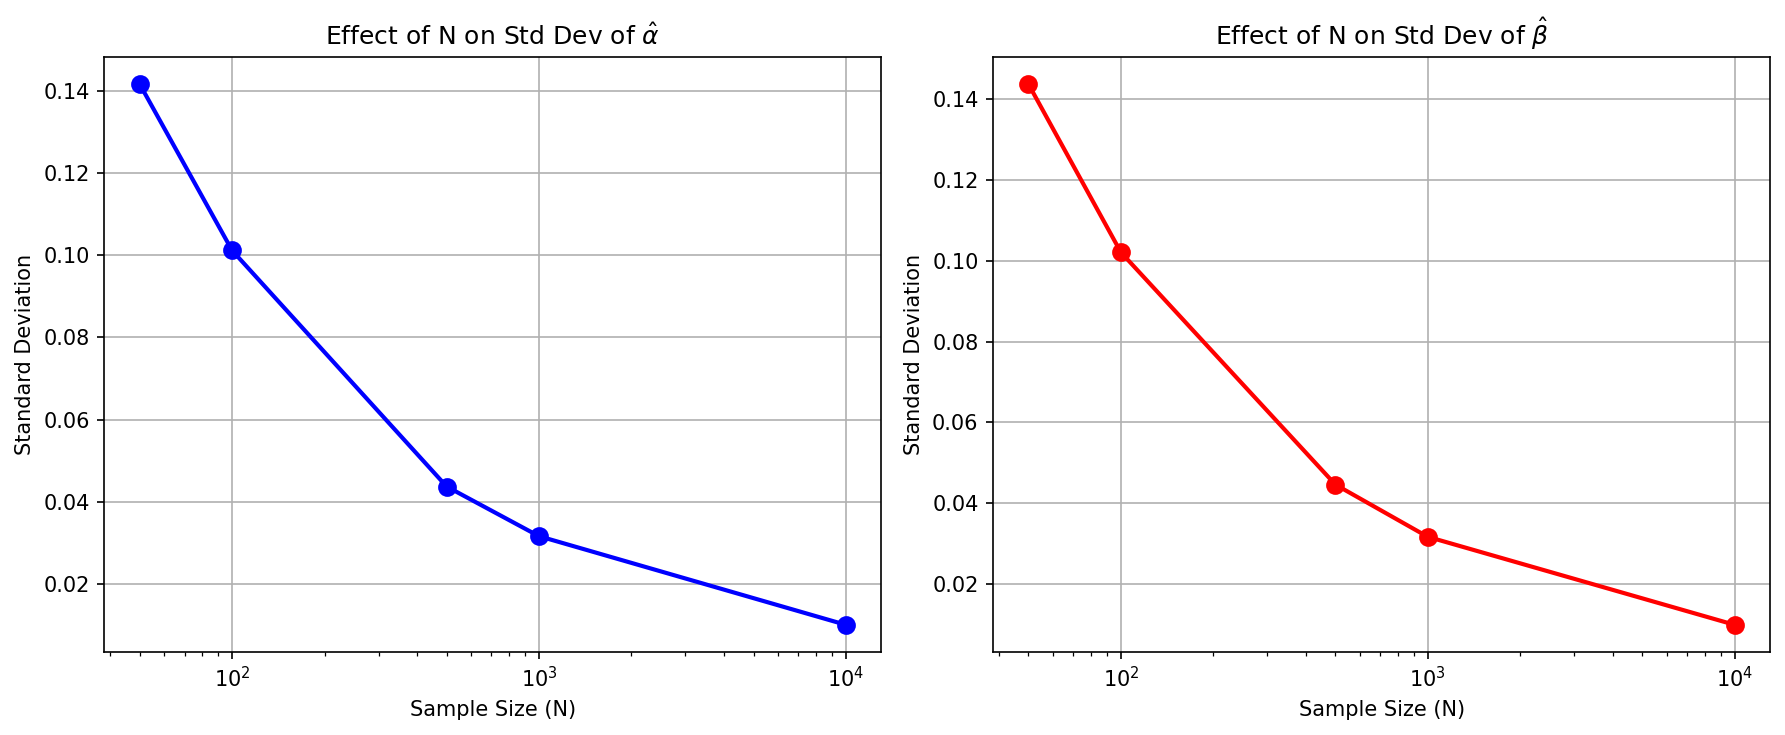

In [39]:
# Plot the effect of N on standard deviation
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

alpha_stds = [results_by_N[N]['standard_deviation']['alpha_hat'] for N in sample_sizes]
beta_stds = [results_by_N[N]['standard_deviation']['beta_hat'] for N in sample_sizes]

ax[0].plot(sample_sizes, alpha_stds, 'bo-', linewidth=2, markersize=8)
ax[0].set_xlabel('Sample Size (N)')
ax[0].set_ylabel('Standard Deviation')
ax[0].set_title(r'Effect of N on Std Dev of $\hat{\alpha}$')
ax[0].set_xscale('log')
ax[0].grid(True)

ax[1].plot(sample_sizes, beta_stds, 'ro-', linewidth=2, markersize=8)
ax[1].set_xlabel('Sample Size (N)')
ax[1].set_ylabel('Standard Deviation')
ax[1].set_title(r'Effect of N on Std Dev of $\hat{\beta}$')
ax[1].set_xscale('log')
ax[1].grid(True)

plt.tight_layout()
plt.savefig('figures/q6_effect_of_N.png', dpi=150, bbox_inches='tight')
plt.show()

### Observations:

As we can see from the simulations with different values of N:

1. **Means remain constant**: The means of $\hat{\alpha}$ and $\hat{\beta}$ remain close to their true values regardless of N, confirming unbiasedness.

2. **Variances decrease**: The standard deviations decrease as N increases, following the relationship $Var(\hat{\beta}) \propto 1/N$. This demonstrates **consistency** of the OLS estimators.

3. **Asymptotic normality**: All distributions converge to normal distributions as N increases, consistent with the Central Limit Theorem.

4. **Rate of convergence**: The standard deviation decreases at rate $1/\sqrt{N}$, so doubling N reduces the standard deviation by a factor of $\sqrt{2} \approx 1.41$.

In [40]:
# Additional test with large N for different distributions
print("\n" + "="*60)
print("Large Sample Tests (N = 10000)")
print("="*60)

print("\nt-distribution:")
_, stats_t_large = run_simulations(M, 10000, dist='t_dist')
print(stats_t_large)
plt.close()

print("\nUniform distribution:")
_, stats_unif_large = run_simulations(M, 10000, dist='uniform_dist')
print(stats_unif_large)
plt.close()

print("\nCorrelated normal:")
_, stats_corr_large = run_simulations(M, 10000, dist='correlated_normal')
print(stats_corr_large)
plt.close()


Large Sample Tests (N = 10000)

t-distribution:
               mean  standard_deviation
alpha_hat  1.000309            0.012951
beta_hat   0.999921            0.009990

Uniform distribution:
               mean  standard_deviation
alpha_hat  1.499988            0.005795
beta_hat   1.000001            0.010102

Correlated normal:
Covariance Matrix:
[[1.  0.5]
 [0.5 1. ]]
               mean  standard_deviation
alpha_hat  0.999986            0.008879
beta_hat   1.499934            0.008720


---
## Summary
---

| Distribution | $\hat{\alpha}$ Unbiased | $\hat{\beta}$ Unbiased | $\hat{\beta}$ Consistent |
|-------------|------------------------|------------------------|-------------------------|
| Standard Normal | Yes | Yes | Yes |
| Correlated Normal | Yes | **No** (biased ~1.5) | **No** |
| t-distribution (df=5) | Yes | Yes | Yes |
| Uniform U[0,1] | **No** (biased ~1.5) | Yes | Yes |

Key findings:
1. OLS estimators are unbiased when exogeneity holds ($E(e|X) = 0$)
2. Correlation between X and e violates exogeneity, causing bias in $\hat{\beta}$
3. Non-zero mean errors cause bias in $\hat{\alpha}$ but not $\hat{\beta}$
4. All estimators are asymptotically normal (CLT) and consistent when exogeneity holds
5. Variance decreases with sample size at rate $1/N$